In [1]:
import numpy as np
import pprint
import torch
from fvcore.nn.precise_bn import get_bn_modules, update_bn_stats

# import timesformer.models.losses as losses
# import timesformer.models.optimizer as optim
import timesformer.utils.checkpoint as cu
import timesformer.utils.distributed as du
import timesformer.utils.logging as logging
import timesformer.utils.metrics as metrics
import timesformer.utils.misc as misc
import timesformer.visualization.tensorboard_vis as tb
# from timesformer.datasets import loader
# from timesformer.models import build_model
from timesformer.utils.meters import TrainMeter, ValMeter
from timesformer.utils.multigrid import MultigridSchedule
from timesformer.datasets.rtmri75s import Rtmri75s
from timm.data import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

logger = logging.get_logger(__name__)

/data2/hongn/miniconda3/envs/sapiens_lite/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from timesformer.utils.parser import load_config, parse_args
cfg = load_config(cfg_file = "/data2/hongn/TimeSformer/configs/Rtmri75s/TimeSformer_divST_8x32_224_4gpus.yaml")


In [5]:
split = "train"

assert split in ["train", "val", "test"]
if split in ["train"]:
    dataset_name = cfg.TRAIN.DATASET
    batch_size = int(cfg.TRAIN.BATCH_SIZE / max(1, cfg.NUM_GPUS))
    shuffle = True
    drop_last = True
elif split in ["val"]:
    dataset_name = cfg.TRAIN.DATASET
    batch_size = int(cfg.TRAIN.BATCH_SIZE / max(1, cfg.NUM_GPUS))
    shuffle = False
    drop_last = False
elif split in ["test"]:
    dataset_name = cfg.TEST.DATASET
    batch_size = int(cfg.TEST.BATCH_SIZE / max(1, cfg.NUM_GPUS))
    shuffle = False
    drop_last = False

# Construct the dataset
dataset = Rtmri75s(cfg, split)

In [6]:
from torch.utils.data._utils.collate import default_collate
from timesformer.datasets import utils as utils

def detection_collate(batch):
    """
    Collate function for detection task. Concatanate bboxes, labels and
    metadata from different samples in the first dimension instead of
    stacking them to have a batch-size dimension.
    Args:
        batch (tuple or list): data batch to collate.
    Returns:
        (tuple): collated detection data batch.
    """
    inputs, labels, video_idx, extra_data = zip(*batch)
    inputs, video_idx = default_collate(inputs), default_collate(video_idx)
    # print(labels, video_idx)
    labels = torch.tensor(list(labels)).float()

    return inputs, labels, video_idx, {}

loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=(False if None else shuffle),
            sampler=None,
            num_workers=cfg.DATA_LOADER.NUM_WORKERS,
            pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
            drop_last=drop_last,
            collate_fn=None,
            worker_init_fn=utils.loader_worker_init_fn(dataset),
        )

In [5]:
for cur_iter, (inputs, labels, _, _) in enumerate(loader):
    break

In [8]:
inputs, labels, _, _ = next(iter(loader))

In [10]:
inputs.shape

torch.Size([24, 3, 8, 224, 224])

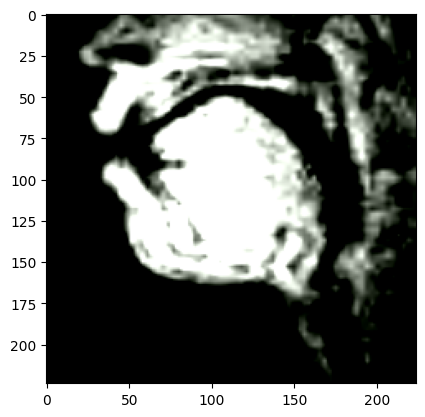

In [11]:
import matplotlib.pyplot as plt
plt.imshow(inputs[1,:,3,:].permute(1, 2, 0))

In [10]:
np.concatenate((3, 0, 0, 0))

ValueError: zero-dimensional arrays cannot be concatenated

In [6]:
data[1].shape

torch.Size([16, 1024])

In [7]:
611846  / 2286 

267.6491688538933

In [8]:
781.0 / 30

26.033333333333335

In [9]:
27 * 50 

1350

In [10]:
(726.9136109523384 - 701.2646993006099) / 2

12.824455825864277

In [11]:
from timesformer.datasets import video_container as container
from timesformer.datasets import decoder as decoder

In [12]:
video_container = container.get_video_container("/data1/span_data/rtmri75s/sub007/2drt/video/sub007_2drt_08_grandfather2_r1_video.mp4")
frames = decoder.decode(
                video_container,
                cfg.DATA.SAMPLING_RATE,
                cfg.DATA.NUM_FRAMES,
                cfg.TEST.NUM_ENSEMBLE_VIEWS,
                target_fps=cfg.DATA.TARGET_FPS,
                backend=cfg.DATA.DECODING_BACKEND,
            )

video_size 2286 start_idx 2259.3510883482713 end_idx 2285.0
video_start_pts 1764553 video_end_pts 1784585 frames_length 2286 duration 1785366 start_idx 2259.3510883482713 end_idx 2285.0
video_size 26 start_idx 0.0 end_idx 25.648911651728554


In [4]:
import av
container = av.open("/data1/hongn/kinetics-dataset/k400/train/3VvkoFtPCCU_000045_000055.mp4")
# total_frames = container.streams.video[0].frames
# total_frames
container

<av.InputContainer '/data1/hongn/kinetics-dataset/k400/train/3VvkoFtPCCU_000045_000055.mp4'>

In [14]:
2286 / 83 / 0.02

1377.1084337349398

In [15]:
in_rate = 83.28
out_rate = 50
len_sample_frames = (2285.0 - 2259.3510883482713) 
duration = len_sample_frames / in_rate
len_frames_in_outrate = duration * 50
len_frames_in_outrate / 2


7.6996012403124

In [16]:
audio_emb = torch.load("/data1/hongn/wav2vec_75speaker/sub007_2drt_08_grandfather2_r1_video.pt")
audio_emb.shape

torch.Size([1, 1376, 1024])

In [17]:
audio_emb

tensor([[[-0.0304,  0.2073,  0.0012,  ..., -0.0881,  0.0155, -0.0250],
         [-0.0300,  0.2083,  0.0015,  ..., -0.0885,  0.0155, -0.0249],
         [-0.0299,  0.2091,  0.0016,  ..., -0.0880,  0.0150, -0.0249],
         ...,
         [-0.0305,  0.2087,  0.0011,  ..., -0.0887,  0.0169, -0.0250],
         [-0.0310,  0.2098,  0.0012,  ..., -0.0875,  0.0173, -0.0243],
         [-0.0913, -0.0404,  0.0123,  ...,  0.2155, -0.0972, -0.0263]]])

In [18]:
int(2259.3510883482713 / in_rate / 0.02)

1356

In [19]:
(2285.0 - 2259.3510883482713) 

25.648911651728667

In [20]:
2286  / 50

45.72

In [21]:
video_container.streams.video

()

In [22]:
video_container.streams.video

()

In [23]:
665/8

83.125

In [24]:
videos, audio_path = data[0], data[1]

In [25]:
videos[1].shape

torch.Size([3, 8, 224, 224])

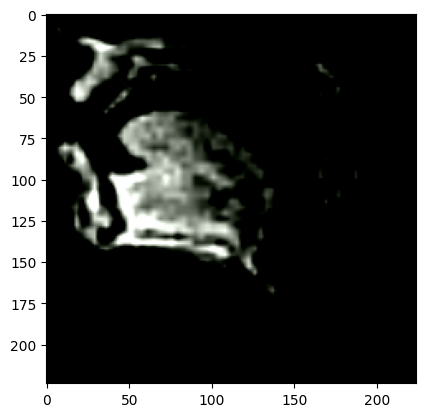

In [26]:
import matplotlib.pyplot as plt
plt.imshow(videos[1][:,0,:].permute(1, 2, 0))

In [27]:
audio_path

tensor([[-0.0306,  0.2078,  0.0010,  ..., -0.0877,  0.0161, -0.0241],
        [-0.0306,  0.2106,  0.0011,  ..., -0.0884,  0.0158, -0.0244],
        [-0.0309,  0.2068,  0.0009,  ..., -0.0879,  0.0164, -0.0242],
        ...,
        [-0.0314,  0.2069,  0.0013,  ..., -0.0873,  0.0160, -0.0252],
        [-0.0316,  0.2066,  0.0013,  ..., -0.0870,  0.0162, -0.0254],
        [-0.0317,  0.2064,  0.0012,  ..., -0.0873,  0.0161, -0.0253]])

In [6]:
import pandas as pd

data = pd.read_csv("/data1/hongn/kinetics-dataset/k400/train.csv", names=["path", "label"])

In [9]:
data.loc[data['path'] == '/data1/hongn/kinetics-dataset/k400/train/bHNHI7SETO4_000216_000226.mp4']

,path,label
85357,/data1/hongn/kinetics-dataset/k400/train/bHNHI...,393


In [10]:
import os
os.path.exists("/data1/hongn/kinetics-dataset/k400/train/bHNHI7SETO4_000216_000226.mp4")

True

In [8]:
data.isin(['/data1/hongn/kinetics-dataset/k400/train/bHNHI7SETO4_000216_000226.mp4'])

,path,label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
241252,False,False
241253,False,False
241254,False,False
241255,False,False


In [3]:
len(data)

241256

## Calculate mean and std of dataset

In [8]:
import numpy as np
from PIL import Image

def calculate_mean_std(image_paths):
    """Calculates mean and standard deviation of a dataset of images.

    Args:
        image_paths (list): List of paths to the images.

    Returns:
        tuple: (mean, std) of the dataset.
    """

    pixel_sum = np.zeros(3)
    pixel_sum_sq = np.zeros(3)
    pixel_count = 0

    for image_path in image_paths:
        image = Image.open(image_path)
        image = np.array(image).astype(np.float32) / 255.0

        pixel_sum += np.sum(image, axis=(0, 1))
        pixel_sum_sq += np.sum(image**2, axis=(0, 1))
        pixel_count += image.shape[0] * image.shape[1]

    mean = pixel_sum / pixel_count
    std = np.sqrt((pixel_sum_sq / pixel_count) - mean**2)

    return mean, std

In [11]:
import glob
image_paths = glob.glob('/data1/span_data/rtmri75s/sub007/3d/snapshot/*')
mean, std = calculate_mean_std(image_paths)

In [13]:

std

array([0.10593245, 0.10593245, 0.10593245])